In [1]:
import pandas as pd
import seaborn as sns
from functools import reduce
from sklearn.metrics import cohen_kappa_score, accuracy_score

# Load df

In [2]:
Automated_data = pd.read_csv('AutomatedAnnotations_All.csv')
Annot_data = pd.read_csv('../1_manual/FinalManualLabels.csv')


In [3]:
Automated_data.head()

,datasetName,folderName,Image,Age,Gender,Race
0,AffectNet - Test,anger,image0000006,30,Woman,white
1,AffectNet - Test,anger,image0000060,34,Man,white
2,AffectNet - Test,anger,image0000061,44,Man,white
3,AffectNet - Test,anger,image0000066,49,Man,white
4,AffectNet - Test,anger,image0000106,30,Man,black


In [4]:
Annot_data.head()

,Image,FolderNames,Final_Age,Final_Gender,Final_Ethnicity
0,ffhq_0.png,neutral,Baby (0-1),Man,Latino/Hispanic
1,ffhq_10.png,happy,Middle-aged Adult (30-49),Woman,White
2,ffhq_107.png,neutral,Older Adult (50-65),Woman,White
3,ffhq_130.png,neutral,Child (2-9),Woman,Asian
4,ffhq_15.png,surprise,Young Adult (20-29),Man,White


# Merge Automated and Manual Annotations

In [5]:
# Clean and standardize the Annot_data
Annot_data.rename(columns={"Final_Age":"Manual_Age" , "Final_Gender":"Manual_Gender" , "Final_Ethnicity":"Manual_Ethnicity" , "FolderNames": "folderName"}, inplace=True)
Annot_data[''] = Annot_data['Image'].str.strip().str.lower()
Annot_data['folderName'] = Annot_data['folderName'].str.strip().str.lower()
Annot_data['Manual_Ethnicity'] = Annot_data['Manual_Ethnicity'].str.strip().str.lower()

# Remove '.jpg' and '.png' extensions from Annot_data image names
Annot_data['Image'] = Annot_data['Image'].str.replace('.jpg', '', regex=False).str.replace('.png', '', regex=False)

# Clean and standardize the Automated_data
Automated_data['Image'] = Automated_data['Image'].str.strip().str.lower()
Automated_data['folderName'] = Automated_data['folderName'].str.strip().str.lower()
Automated_data.rename(columns={"Age":"Automated_Age" , "Gender":"Automated_Gender" , "Race":"Automated_Ethnicity"}, inplace=True)

# Remove ' - Test' from datasetName in the Automated_data
Automated_data['datasetName'] = Automated_data['datasetName'].str.replace(' - Test', '', regex=False)

# Filter the Automated_data for 'AffectNet'
Automated_data_filtered = Automated_data[Automated_data['datasetName'] == 'AffectNet']

# Merge Annot_data and filtered Automated_data on Image
# and folderName
merged_data_filtered = pd.merge(
    Automated_data_filtered,
    Annot_data,
    on=["Image", "folderName"],
    how="inner"
)

# Rename columns as needed (e.g., Race to Ethnicity)
merged_data_filtered = merged_data_filtered.rename(columns={'Race': 'Automated_Ethnicity'})

# Map Ethnicity categories to standardize them
ethnicity_mapping = {
    'latino/hispanic': 'latino hispanic',
    'white': 'white',
    'asian': 'asian',
    'black': 'black',
    'indian': 'indian',
    'middle eastern': 'middle eastern',
    'ambiguous': None  # Handle ambiguous as NaN or ignore
}

# Align the ethnicity column in the merged dataset
merged_data_filtered['Manual_Ethnicity'] = merged_data_filtered['Manual_Ethnicity'].map(ethnicity_mapping)

# Define the age group function
def create_age_group(age):
    if age is None or age == '':
        return 'Unknown'  # Return 'Unknown' or any default label for missing values
    elif age < 2:
        return 'Baby (0-1)'
    elif 2 <= age < 10:
        return 'Child (2-9)'
    elif 10 <= age < 20:
        return 'Adolescent (10-19)'
    elif 20 <= age < 30:
        return 'Young Adult (20-29)'
    elif 30 <= age < 50:
        return 'Middle-aged Adult (30-49)'
    elif 50 <= age < 65:
        return 'Older Adult (50-65)'
    else:
        return 'Elderly (65+)'


# Apply the age group function to relevant columns
merged_data_filtered['Automated_Age'] = merged_data_filtered['Automated_Age'].apply(create_age_group)
merged_data = merged_data_filtered.copy()
merged_data.head()
# Optionally, save the merged data to a new CSV file
#merged_data.to_csv('merged_annotations_and_analysis.csv', index=False)


,datasetName,folderName,Image,Automated_Age,Automated_Gender,Automated_Ethnicity,Manual_Age,Manual_Gender,Manual_Ethnicity,
0,AffectNet,anger,image0001063,Middle-aged Adult (30-49),Woman,white,Baby (0-1),Man,white,image0001063.jpg
1,AffectNet,anger,image0003108,Middle-aged Adult (30-49),Man,middle eastern,Middle-aged Adult (30-49),Man,middle eastern,image0003108.jpg
2,AffectNet,contempt,image0006264,Young Adult (20-29),Woman,black,Young Adult (20-29),Woman,black,image0006264.jpg
3,AffectNet,contempt,image0013196,Older Adult (50-65),Man,asian,Elderly (65+),Man,asian,image0013196.jpg
4,AffectNet,contempt,image0019021,Middle-aged Adult (30-49),Woman,asian,Young Adult (20-29),Woman,asian,image0019021.jpg


# Access accuracy

In [6]:
df = merged_data.copy()
# Compare columns and calculate agreement
df['Age_Match'] = df['Manual_Age'] == df['Automated_Age']
df['Gender_Match'] = df['Manual_Gender'] == df['Automated_Gender']
df['Ethnicity_Match'] = df['Manual_Ethnicity'] == df['Automated_Ethnicity']

# Calculate overall agreement percentage for each attribute
age_accuracy = df['Age_Match'].mean() * 100
gender_accuracy = df['Gender_Match'].mean() * 100
ethnicity_accuracy = df['Ethnicity_Match'].mean() * 100

print(f"Age Agreement: {age_accuracy:.2f}%")
print(f"Gender Agreement: {gender_accuracy:.2f}%")
print(f"Ethnicity Agreement: {ethnicity_accuracy:.2f}%")


Age Agreement: 39.47%
Gender Agreement: 73.68%
Ethnicity Agreement: 73.68%


# Cohen's Kappa
Given that the manual annotations are considered ground truth and the automated system produces deterministic outputs (class labels), calculating Cohen's Kappa makes sense. It will evaluate the agreement between the automated system's predictions and the ground truth (manual annotations), while accounting for chance agreement.

In [7]:
# Replace NaN or None with 'Unknown' for all relevant columns
df['Manual_Age'] = df['Manual_Age'].fillna('Unknown')
df['Automated_Age'] = df['Automated_Age'].fillna('Unknown')
df['Manual_Gender'] = df['Manual_Gender'].fillna('Unknown')
df['Automated_Gender'] = df['Automated_Gender'].fillna('Unknown')
df['Manual_Ethnicity'] = df['Manual_Ethnicity'].fillna('Unknown')
df['Automated_Ethnicity'] = df['Automated_Ethnicity'].fillna('Unknown')


# Compute Cohen's Kappa for each attribute
age_kappa = cohen_kappa_score(df['Manual_Age'], df['Automated_Age'])
gender_kappa = cohen_kappa_score(df['Manual_Gender'], df['Automated_Gender'])
ethnicity_kappa = cohen_kappa_score(df['Manual_Ethnicity'], df['Automated_Ethnicity'])

# Print results
print(f"Age Cohen's Kappa: {age_kappa:.2f}")
print(f"Gender Cohen's Kappa: {gender_kappa:.2f}")
print(f"Ethnicity Cohen's Kappa: {ethnicity_kappa:.2f}")


Age Cohen's Kappa: 0.23
Gender Cohen's Kappa: 0.40
Ethnicity Cohen's Kappa: 0.68


# Plot

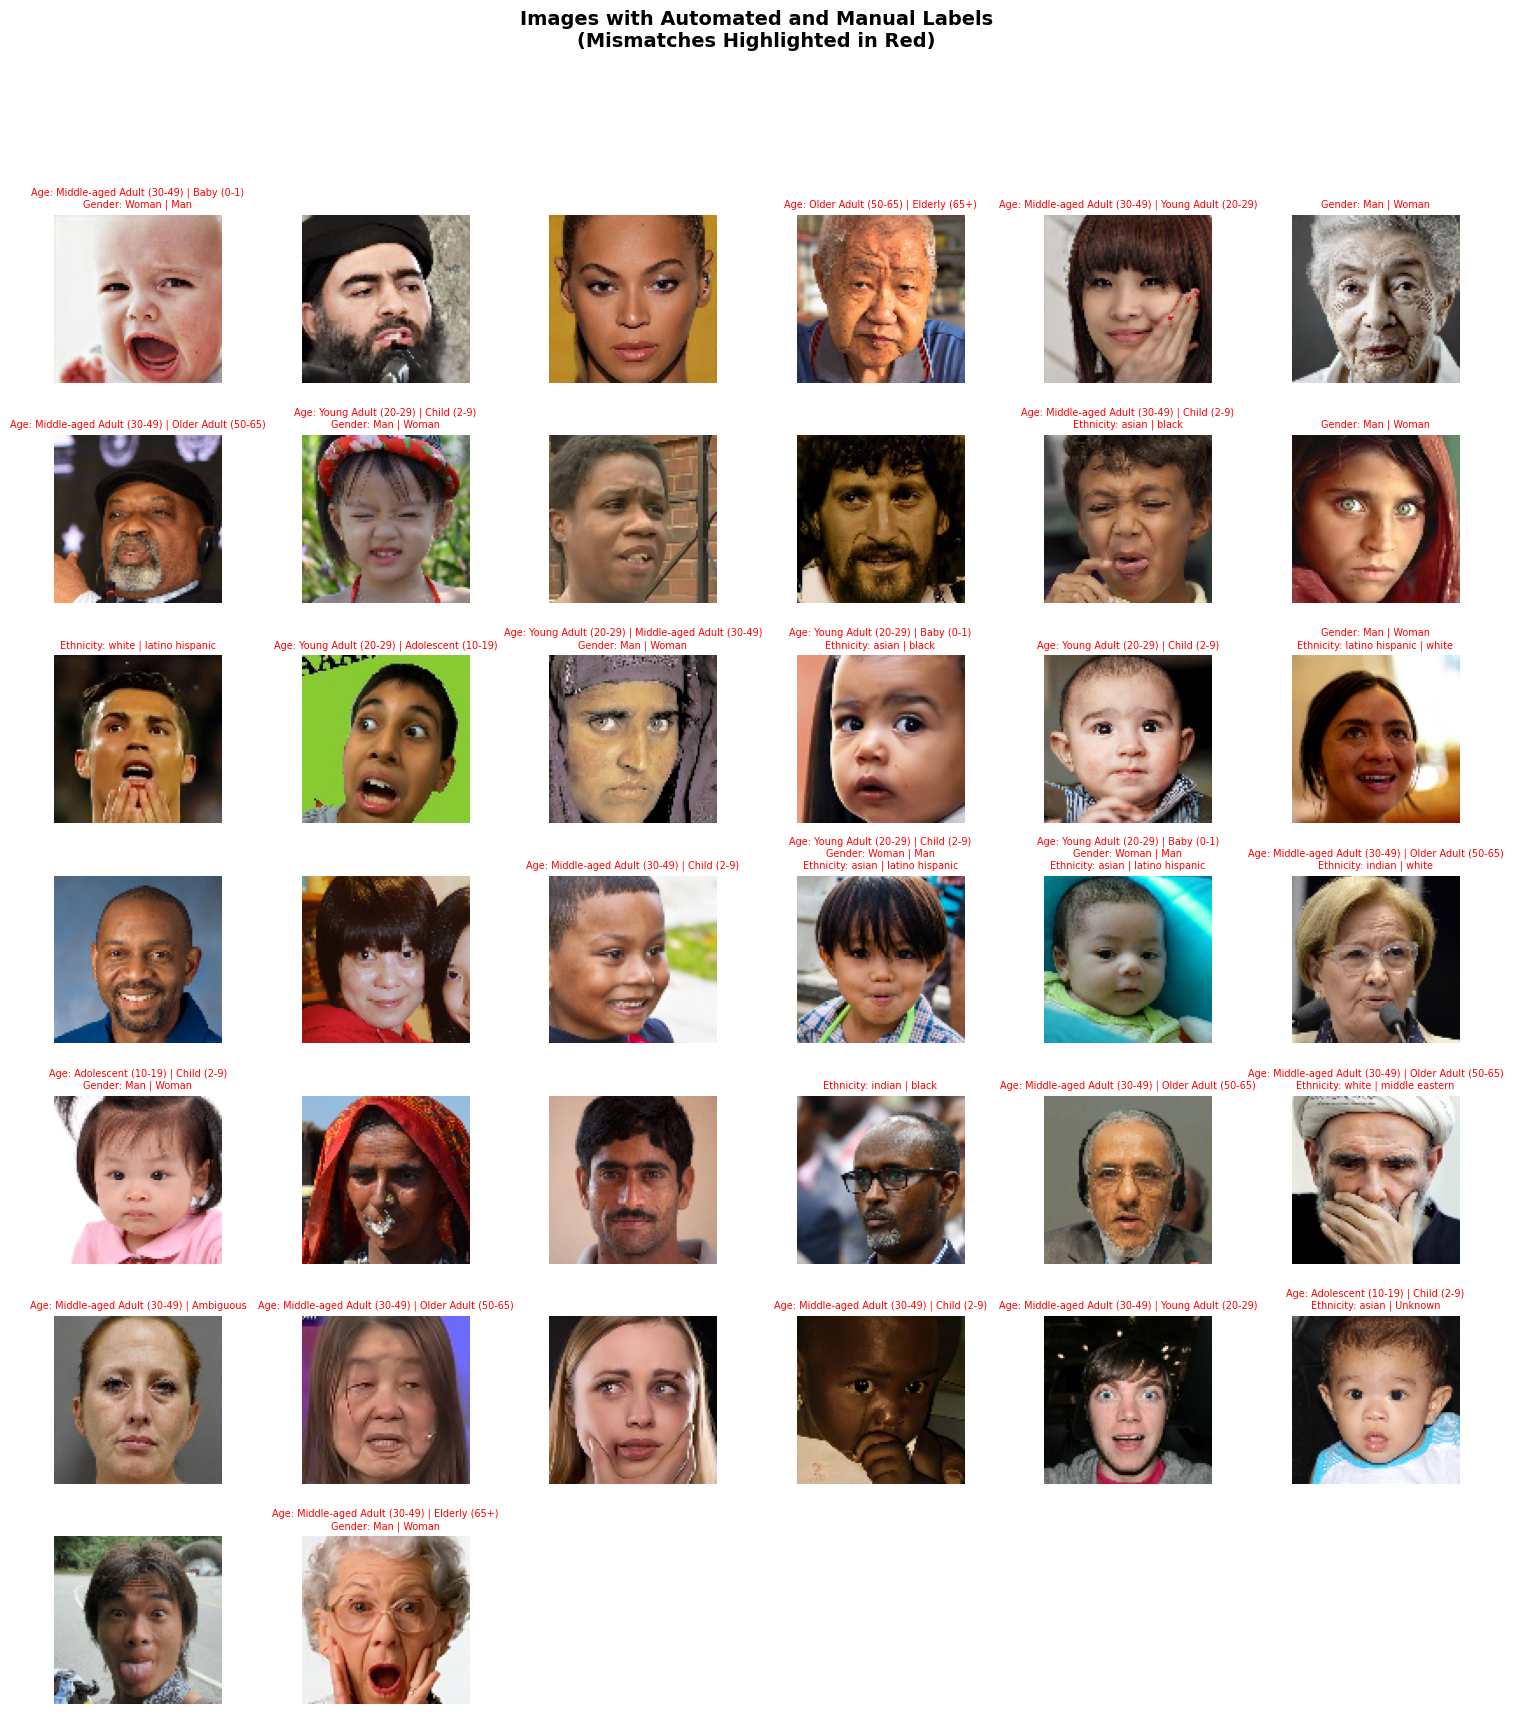

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set base directory path
base_dir = "../../3_image_datasets/affectnet/SelectionManualAnnotation/AffectNet"  # Replace with the actual path

# Set up the grid dimensions
fig, axes = plt.subplots(7, 6, figsize=(15, 18))  # Increase figure size for better spacing

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Track the index of the image we're displaying
for idx, (index, row) in enumerate(df.iterrows()):
    if idx >= 42:  # Stop after displaying 42 images (6x7 grid)
        break

    image_name = row["Image"]
    folder_name = row["folderName"]
    
    # Add file extension (.jpg or .png) if missing
    possible_extensions = [".jpg", ".png"]
    image_path = None
    for ext in possible_extensions:
        test_path = os.path.join(base_dir, folder_name, image_name + ext)
        if os.path.exists(test_path):
            image_path = test_path
            break

    # If the image file is not found, skip this row
    if not image_path:
        print(f"Image not found: {image_name} in folder {folder_name}")
        continue

    # Try to open the image file
    img = Image.open(image_path)

    # Display the image on the grid
    axes[idx].imshow(img)
    axes[idx].axis("off")
    
    # Extract labels
    auto_age = row["Automated_Age"]
    manual_age = row["Manual_Age"]
    auto_gender = row["Automated_Gender"]
    manual_gender = row["Manual_Gender"]
    auto_ethnicity = row["Automated_Ethnicity"]
    manual_ethnicity = row["Manual_Ethnicity"]

    # Determine mismatched labels
    mismatches = {
        "Age": (auto_age, manual_age),
        "Gender": (auto_gender, manual_gender),
        "Ethnicity": (auto_ethnicity, manual_ethnicity),
    }

    # Highlight mismatched labels and create the title
    title_lines = []
    for category, (auto, manual) in mismatches.items():
        if auto != manual:
            title_lines.append(f"{category}: {auto} | {manual}")  # Highlight mismatched labels

    # Set title with mismatched categories
    title = "\n".join(title_lines)
    axes[idx].set_title(title, fontsize=7, color="red" if title_lines else "black", loc="center")

# Hide any remaining empty subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

# Add a main title for the entire figure
fig.suptitle(
    "Images with Automated and Manual Labels\n(Mismatches Highlighted in Red)", 
    fontsize=14, fontweight="bold"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # Adjust layout to fit the main title
plt.savefig('MismatchedLabelsWithPictures.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [19]:
import pandas as pd
import numpy as np

# Assuming "merged_data" is your DataFrame containing automated and manual labels.

# Identify mismatches
mismatches = merged_data[
    (merged_data['Automated_Age'] != merged_data['Manual_Age']) |
    (merged_data['Automated_Gender'] != merged_data['Manual_Gender']) |
    (merged_data['Automated_Ethnicity'] != merged_data['Manual_Ethnicity'])
]

# Initialize matrices for mismatched labels
age_mismatch_matrix = pd.crosstab(
    mismatches['Manual_Age'], mismatches['Automated_Age'], rownames=['Manual Age'], colnames=['Automated Age'], dropna=False
)

gender_mismatch_matrix = pd.crosstab(
    mismatches['Manual_Gender'], mismatches['Automated_Gender'], rownames=['Manual Gender'], colnames=['Automated Gender'], dropna=False
)

ethnicity_mismatch_matrix = pd.crosstab(
    mismatches['Manual_Ethnicity'], mismatches['Automated_Ethnicity'], rownames=['Manual Ethnicity'], colnames=['Automated Ethnicity'], dropna=False
)

# Summary statistics for mismatches
age_mismatch_counts = mismatches[mismatches['Automated_Age'] != mismatches['Manual_Age']]['Automated_Age'].value_counts()
gender_mismatch_counts = mismatches[mismatches['Automated_Gender'] != mismatches['Manual_Gender']]['Automated_Gender'].value_counts()
ethnicity_mismatch_counts = mismatches[mismatches['Automated_Ethnicity'] != mismatches['Manual_Ethnicity']]['Automated_Ethnicity'].value_counts()

# Display results
print("Age Mismatch Matrix:")
print(age_mismatch_matrix)
print("\nGender Mismatch Matrix:")
print(gender_mismatch_matrix)
print("\nEthnicity Mismatch Matrix:")
print(ethnicity_mismatch_matrix)

print("\nSignificant Age Mismatches:")
print(age_mismatch_counts)
print("\nSignificant Gender Mismatches:")
print(gender_mismatch_counts)
print("\nSignificant Ethnicity Mismatches:")
print(ethnicity_mismatch_counts)

Age Mismatch Matrix:
Automated Age              Adolescent (10-19)  Elderly (65+)  \
Manual Age                                                     
Adolescent (10-19)                          0              0   
Ambiguous                                   0              0   
Baby (0-1)                                  0              0   
Child (2-9)                                 2              0   
Elderly (65+)                               0              1   
Middle-aged Adult (30-49)                   0              0   
Older Adult (50-65)                         0              0   
Young Adult (20-29)                         0              0   

Automated Age              Middle-aged Adult (30-49)  Older Adult (50-65)  \
Manual Age                                                                  
Adolescent (10-19)                                 0                    0   
Ambiguous                                          1                    0   
Baby (0-1)                    

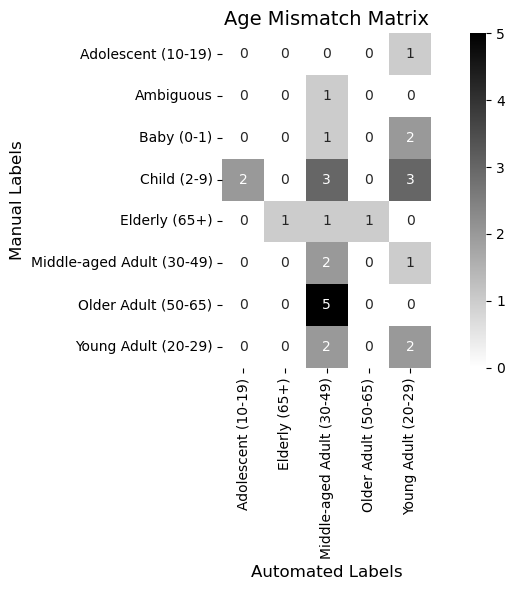

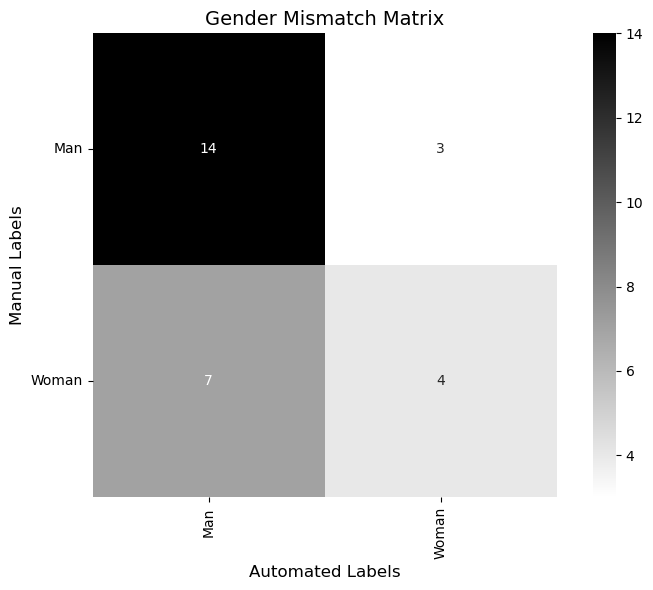

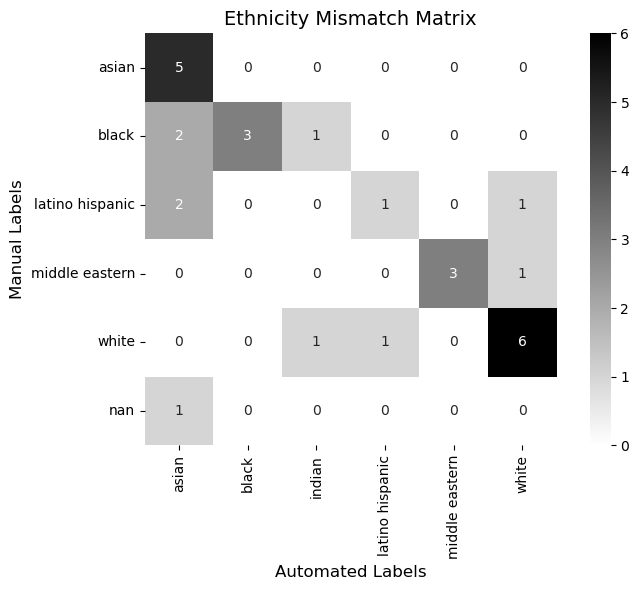

In [29]:
 




# Function to plot heatmaps for mismatch matrices
def plot_mismatch_matrix(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', cbar=True, square=True)
    plt.title(title, fontsize=14)
    plt.ylabel('Manual Labels', fontsize=12)
    plt.xlabel('Automated Labels', fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(title+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Plot heatmaps for Age, Gender, and Ethnicity mismatches
plot_mismatch_matrix(age_mismatch_matrix, "Age Mismatch Matrix")
plot_mismatch_matrix(gender_mismatch_matrix, "Gender Mismatch Matrix")
plot_mismatch_matrix(ethnicity_mismatch_matrix, "Ethnicity Mismatch Matrix")

# Access Accuracy and Cohen's Kappa for JAFFE data

In [9]:

jaffe_data = Automated_data[Automated_data['datasetName'] == 'JAFFE']

# Define ground truth for JAFFE
ground_truth_gender = ['Woman'] * len(jaffe_data)
ground_truth_Ethnicity = ['asian'] * len(jaffe_data)

# Calculate Gender accuracy and Cohen's Kappa
gender_accuracy = accuracy_score(ground_truth_gender, jaffe_data['Automated_Gender'])
gender_kappa = cohen_kappa_score(ground_truth_gender, jaffe_data['Automated_Gender'])

# Calculate Ethnicity accuracy and Cohen's Kappa
Ethnicity_accuracy = accuracy_score(ground_truth_Ethnicity, jaffe_data['Automated_Ethnicity'])
Ethnicity_kappa = cohen_kappa_score(ground_truth_Ethnicity, jaffe_data['Automated_Ethnicity'])

# Display results
results = {
    "Gender Accuracy": gender_accuracy * 100,
    "Gender Kappa": gender_kappa,
    "Ethnicity Accuracy": Ethnicity_accuracy * 100,
    "Ethnicity Kappa": Ethnicity_kappa
}

results

{'Gender Accuracy': 43.66197183098591,
 'Gender Kappa': 0.0,
 'Ethnicity Accuracy': 86.3849765258216,
 'Ethnicity Kappa': 0.0}

C:\Users\liter\AppData\Local\Temp\ipykernel_24304\4069038296.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\liter\AppData\Local\Temp\ipykernel_24304\4069038296.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\liter\AppData\Local\Temp\ipykernel_24304\4069038296.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\liter\AppData\Local\Temp\ipykernel_24304\4069038296.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable

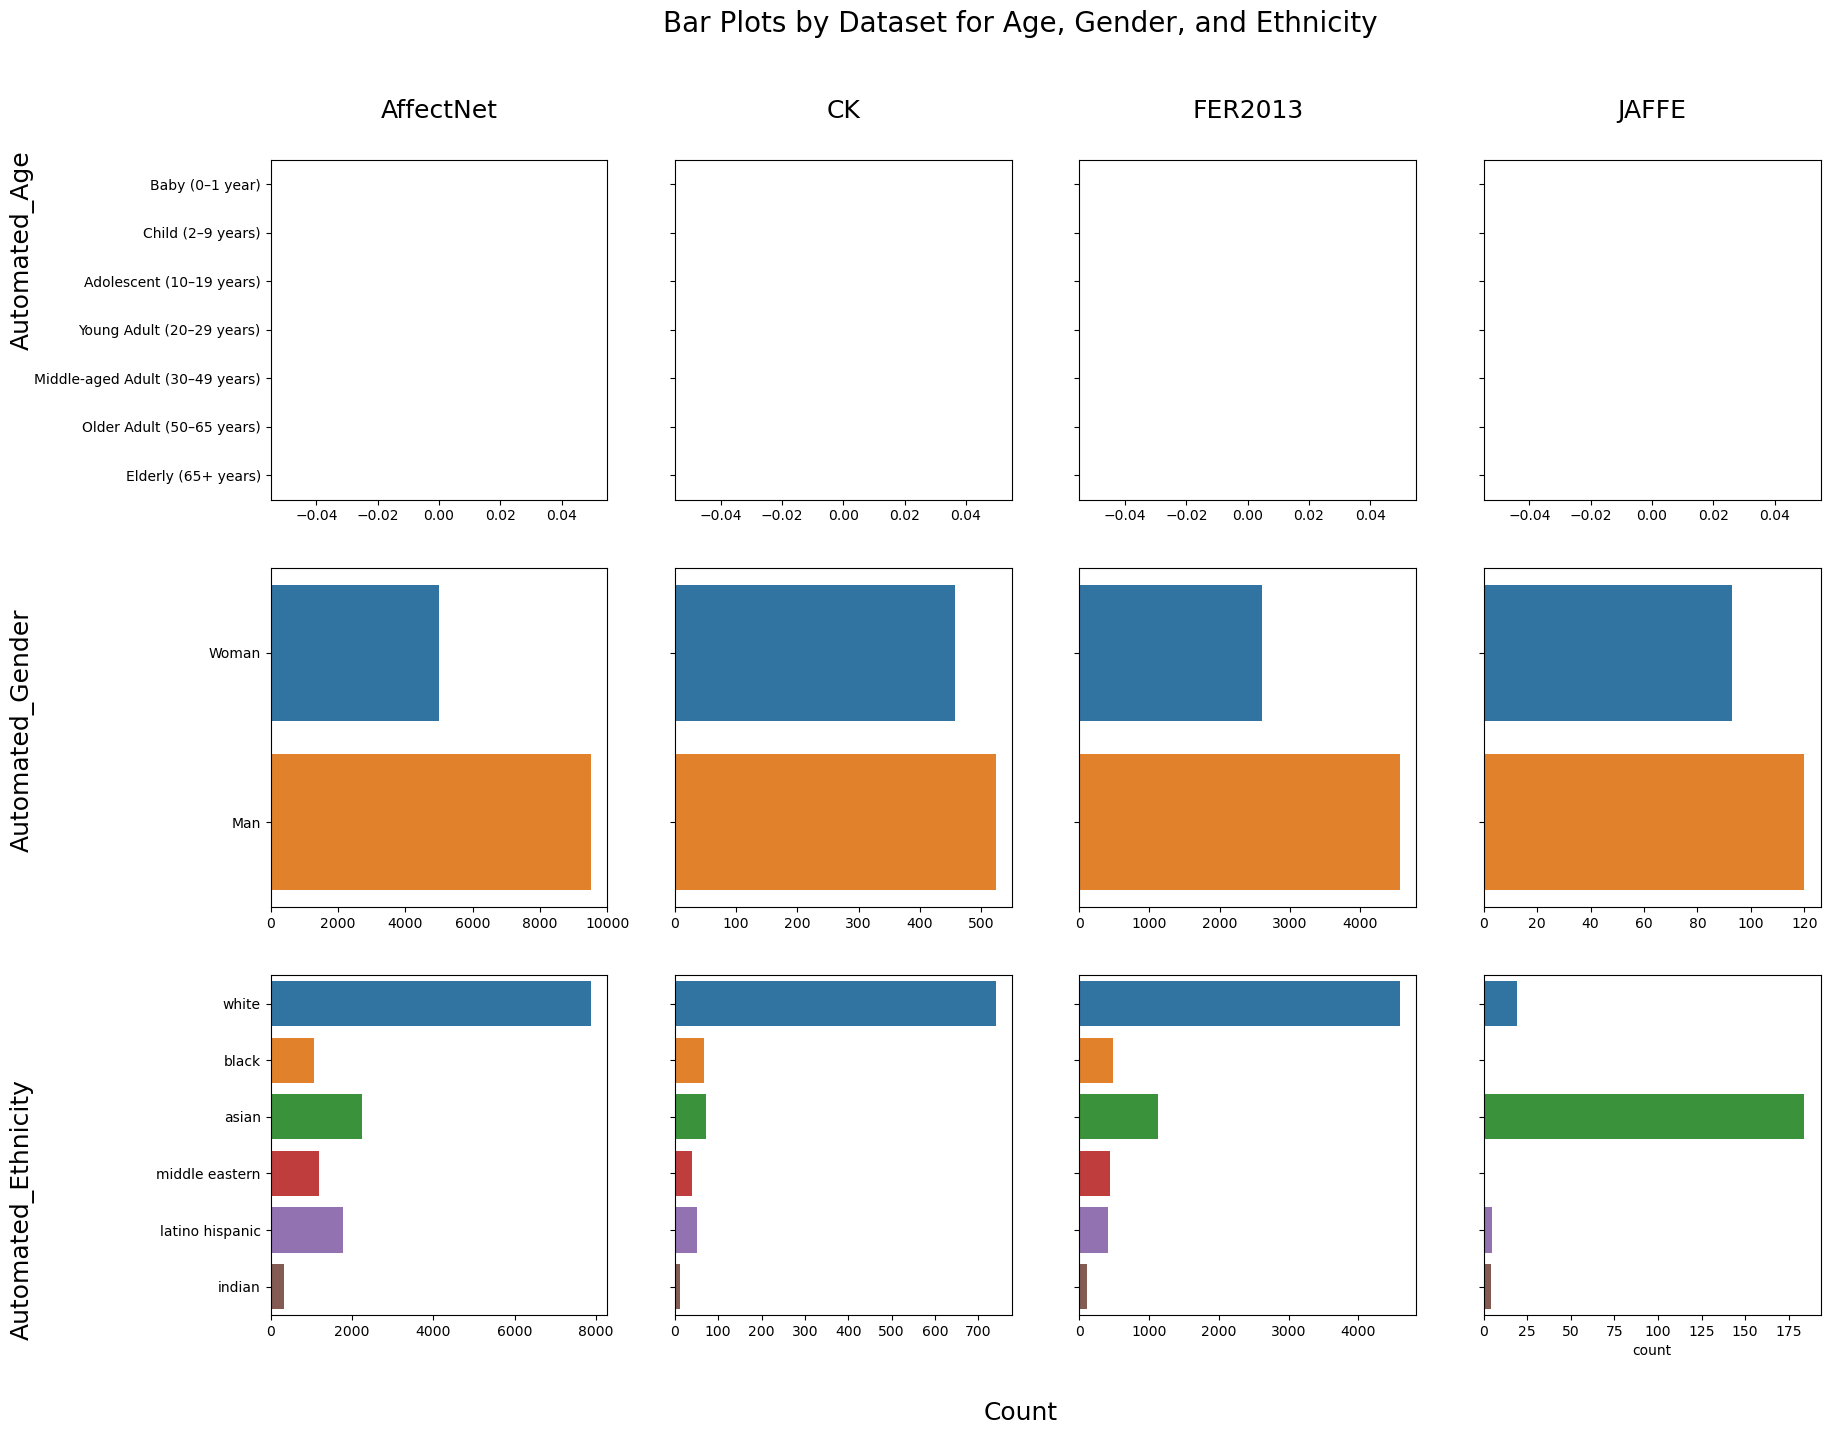

In [23]:
automated_data = Automated_data.copy()
automated_data['Automated_Age'] = automated_data['Automated_Age'].apply(create_age_group)

# Update values in the 'Ethnicity' column where 'datasetName' is "JAFFE"
automated_data.loc[automated_data['datasetName'] == 'JAFFE', 'Ethnicity'] = 'asian'
automated_data.loc[automated_data['datasetName'] == 'JAFFE', 'Gender'] = 'Woman'

# Define the consistent order for categories
gender_order = ["Woman", "Man"]
ethnicity_order = ["white", "black", "asian", "middle eastern", "latino hispanic", "indian"]
age_category_order = [
    "Baby (0–1 year)", "Child (2–9 years)", "Adolescent (10–19 years)",
    "Young Adult (20–29 years)", "Middle-aged Adult (30–49 years)",
    "Older Adult (50–65 years)", "Elderly (65+ years)"
]

# Get unique datasets
datasets = automated_data['datasetName'].unique()

# Set up the figure
fig, axes = plt.subplots(3, len(datasets), figsize=(20, 15), sharey='row')
fig.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust spacing between subplots

# Set consistent color palette
palette = sns.color_palette("tab10", n_colors=max(len(gender_order), len(ethnicity_order)))

# Define row titles
row_titles = ["Automated_Age", "Automated_Gender", "Automated_Ethnicity"]

# Set a consistent label padding
label_padding = 40

# Loop through datasets and create plots
for row_idx, row_title in enumerate(row_titles):
    for col_idx, dataset in enumerate(datasets):
        # Filter data for the current dataset
        data_subset = automated_data[automated_data['datasetName'] == dataset]
        
        # Bar plot for each row
        if row_idx == 0:  # Row 1: Age
            sns.countplot(
                data=data_subset,
                y="Automated_Age",
                order=age_category_order,
                color=palette[0],
                ax=axes[row_idx, col_idx]
            )
            axes[row_idx, col_idx].set_ylabel('')  # Remove y-axis labels for other plots
            axes[row_idx, col_idx].set_title(f"{dataset}", fontsize=18, y=1.1)  # Bigger plot titles
            axes[row_idx, col_idx].set_xlabel('')  # Remove x-axis label
        
        elif row_idx == 1:  # Row 2: Gender
            sns.countplot(
                data=data_subset,
                y="Automated_Gender",
                order=gender_order,
                palette=palette[:len(gender_order)],
                ax=axes[row_idx, col_idx]
            )
            
            axes[row_idx, col_idx].set_ylabel('')  # Remove y-axis labels for other plots
            axes[row_idx, col_idx].set_title('', fontsize=18)  # No titles for second row
            axes[row_idx, col_idx].set_xlabel('')  # Remove x-axis label
        
        elif row_idx == 2:  # Row 3: Ethnicity
            sns.countplot(
                data=data_subset,
                y="Automated_Ethnicity",
                order=ethnicity_order,
                palette=palette[:len(ethnicity_order)],
                ax=axes[row_idx, col_idx]
            )
            axes[row_idx, col_idx].set_ylabel('')  # Remove y-axis labels for other plots
            axes[row_idx, col_idx].set_title('', fontsize=18)  # No titles for third row
            if col_idx != len(datasets) - 1:
                axes[row_idx, col_idx].set_xlabel('')  # Remove x-axis labels for all but the last row

                
                
# Add perfectly aligned row titles
for row_idx, row_title in enumerate(row_titles):
    fig.text(
        0.001, 0.82 - row_idx * 0.32,  # Adjust vertical alignment for each row
        row_title, 
        va='center', ha='center', fontsize=18, rotation='vertical')

                
                
# Add shared x-axis label for the last row
fig.text(0.5, 0.04, "Count", ha='center', fontsize=18)

# Add overall title
fig.suptitle("Bar Plots by Dataset for Age, Gender, and Ethnicity", fontsize=20, y=0.98)

# Show plot
plt.show()


C:\Users\liter\AppData\Local\Temp\ipykernel_24304\1258346204.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\liter\AppData\Local\Temp\ipykernel_24304\1258346204.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\liter\AppData\Local\Temp\ipykernel_24304\1258346204.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\liter\AppData\Local\Temp\ipykernel_24304\1258346204.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable

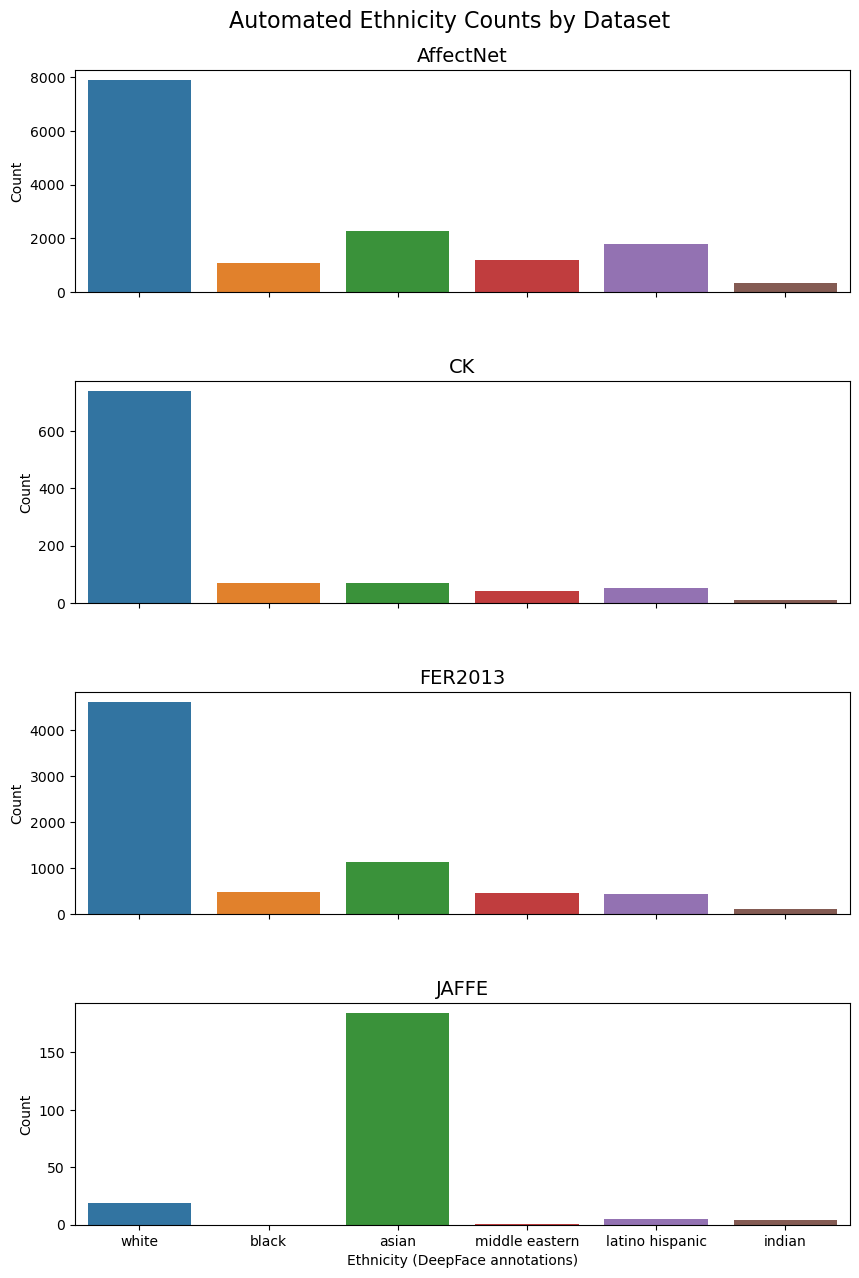

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the consistent order for ethnicity categories
ethnicity_order = ["white", "black", "asian", "middle eastern", "latino hispanic", "indian"]

# Get unique datasets
datasets = automated_data['datasetName'].unique()

# Set up the figure
fig, axes = plt.subplots(len(datasets), 1, figsize=(10, 15), sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between subplots

# Set consistent color palette
palette = sns.color_palette("tab10", n_colors=len(ethnicity_order))

# Loop through datasets and create plots
for row_idx, dataset in enumerate(datasets):
    # Filter data for the current dataset
    data_subset = automated_data[automated_data['datasetName'] == dataset]

    # Bar plot for Ethnicity
    sns.countplot(
        data=data_subset,
        x="Automated_Ethnicity",
        order=ethnicity_order,
        palette=palette,
        ax=axes[row_idx]
    )
    
    axes[row_idx].set_xlabel('Ethnicity (DeepFace annotations)' if row_idx == len(datasets) - 1 else '')  # Add x-axis label for the last plot only
    axes[row_idx].set_ylabel("Count")
    axes[row_idx].set_title(f"{dataset}", fontsize=14)  # Add dataset name as title

# Add overall title
fig.suptitle("Automated Ethnicity Counts by Dataset", fontsize=16, y=0.92)
plt.savefig('AutomatedEthnicityCountsbyDataset.pdf', format='pdf', bbox_inches='tight')
# Show plot
plt.show()